In [6]:
import numpy as np
import pandas as pd
from subprocess import check_output
from keras.layers import Dense,Activation,Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense


In [16]:
data=pd.read_csv('NFLX.csv')
data[0:3]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
1,2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002,17284900
2,2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997,17948100


In [18]:
n=len(data)
train_data=data[0:(n//10)*9]
test_data=data[(n//10)*9:]

In [19]:
print(len(train_data))
print(len(test_data))

900
107


In [20]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_data['Open'].values.reshape(-1,1))

In [21]:
prediction_days = 30

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)-10):      ######
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+10, 0])      ###### predict 10 days after
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [22]:
print(x_train.shape)
print(y_train.shape)

(860, 30, 1)
(860,)


In [23]:
def LSTM_model():
    
    model = Sequential()    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    return model

In [24]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])  

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 30, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 1, save_best_only = True)
his=model.fit(x_train,y_train,epochs=20,batch_size=32,callbacks=[checkpointer])

Epoch 1/20
27/27 [==============================] - 12s 53ms/step - loss: 0.0373 - accuracy: 0.0012
Epoch 2/20
27/27 [==============================] - 1s 54ms/step - loss: 0.0074 - accuracy: 0.0012
Epoch 3/20
27/27 [==============================] - 2s 58ms/step - loss: 0.0084 - accuracy: 0.0012
Epoch 4/20
27/27 [==============================] - 2s 57ms/step - loss: 0.0073 - accuracy: 0.0012
Epoch 5/20
27/27 [==============================] - 2s 56ms/step - loss: 0.0069 - accuracy: 0.0012
Epoch 6/20
27/27 [==============================] - 1s 48ms/step - loss: 0.0074 - accuracy: 0.0012
Epoch 7/20
27/27 [==============================] - 2s 63ms/step - loss: 0.0065 - accuracy: 0.0012
Epoch 8/20
27/27 [==============================] - 1s 51ms/step - loss: 0.0074 - accuracy: 0.0012
Epoch 9/20
27/27 [==============================] - 1s 52ms/step - loss: 0.0071 - accuracy: 0.0012
Epoch 10/20
27/27 [==============================] - 2s 58ms/step - loss: 0.0062 - accuracy: 0.0012
Epoch 11

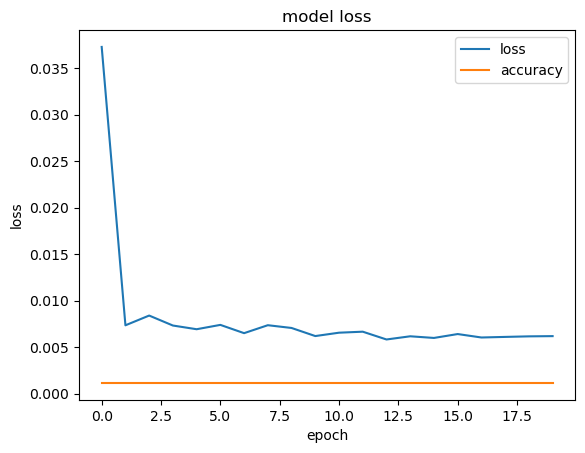

In [28]:
plt.plot(his.history['loss'])
plt.plot(his.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'], loc='upper right')
plt.show()

In [29]:
actual_prices = test_data['Open'].values
total_dataset = pd.concat((train_data['Open'], test_data['Open']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [30]:
x_test = []
for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

4/4 [==============================] - 2s 19ms/step


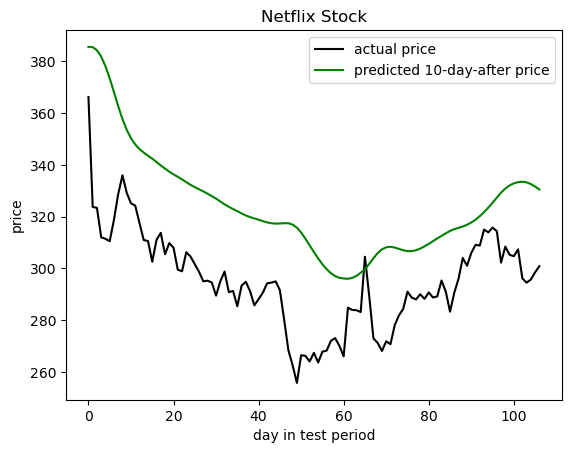

In [31]:
plt.plot(actual_prices, color='black', label=f"actual price")
plt.plot(predicted_prices, color= 'green', label=f"predicted 10-day-after price")
plt.title(f"Netflix Stock")
plt.xlabel("day in test period")
plt.ylabel(f"price")
plt.legend()
plt.show()

In [32]:
real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))
print(real_data.shape)

(1, 29, 1)


In [33]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction[0][0]}")

1/1 [==============================] - 2s 2s/step
prediction: 329.46923828125
